**Landmark-Based Analysis**

In [ ]:
!pip install mediapipe

In [ ]:
#extract landmarks
import cv2
import mediapipe as mp
import numpy as np
from google.colab.patches import cv2_imshow

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

image = cv2.imread("/content/bodytype.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pose.process(image_rgb)

if results.pose_landmarks:
    landmarks = results.pose_landmarks.landmark  # Get the landmarks
else:
    print("Pose landmarks not detected in the image.")
    # Handle the case where landmarks are not found (e.g., exit or use a default value)z: {landmark.z}, visibility: {landmark.visibility}")

In [ ]:
#Calculate Body Ratios
def calculate_body_ratios(landmarks):
    """Calculates body ratios using MediaPipe pose landmarks."""

    # Shoulder Width
    shoulder_width = np.linalg.norm(np.array([landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]) - np.array([landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]))

    # Hip Width
    hip_width = np.linalg.norm(np.array([landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]) - np.array([landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]))

    # Waist Width (estimated)
    left_waist_x = (landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x + landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x) / 2
    left_waist_y = (landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y + landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y) / 2
    right_waist_x = (landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x + landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x) / 2
    right_waist_y = (landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y + landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y) / 2
    waist_width = np.linalg.norm(np.array([left_waist_x, left_waist_y]) - np.array([right_waist_x, right_waist_y]))

    # Leg Length
    leg_length = np.linalg.norm(np.array([landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]) - np.array([landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]))

    # Body Length (from nose to hip)
    body_length = np.linalg.norm(np.array([landmarks[mp_pose.PoseLandmark.NOSE.value].x, landmarks[mp_pose.PoseLandmark.NOSE.value].y]) - np.array([landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]))

    # Calculate ratios
    shoulder_to_hip_ratio = shoulder_width / hip_width
    waist_to_hip_ratio = waist_width / hip_width
    leg_to_body_ratio = leg_length / body_length

    if shoulder_to_hip_ratio > 1.1 and waist_to_hip_ratio < 0.8:
        body_type = "Inverted Triangle"
    elif shoulder_to_hip_ratio < 0.9 and waist_to_hip_ratio > 0.85:
        body_type = "Pear"
    elif shoulder_to_hip_ratio >= 0.9 and shoulder_to_hip_ratio <= 1.1 and waist_to_hip_ratio >= 0.7 and waist_to_hip_ratio <= 0.85:
        body_type = "Hourglass"
    elif leg_to_body_ratio > 1.2:
        body_type = "Long Legs"
    elif leg_to_body_ratio < 0.8:
        body_type = "Short Legs"
    else:
        body_type = "Rectangle"

    return shoulder_to_hip_ratio, waist_to_hip_ratio, leg_to_body_ratio, body_type


In [ ]:
# Calculate ratios
shoulder_to_hip_ratio, waist_to_hip_ratio, leg_to_body_ratio,body_type= calculate_body_ratios(landmarks)

# Print the result
print("Body Type:", body_type)

Body Type: Rectangle


**Countour Based Approach**

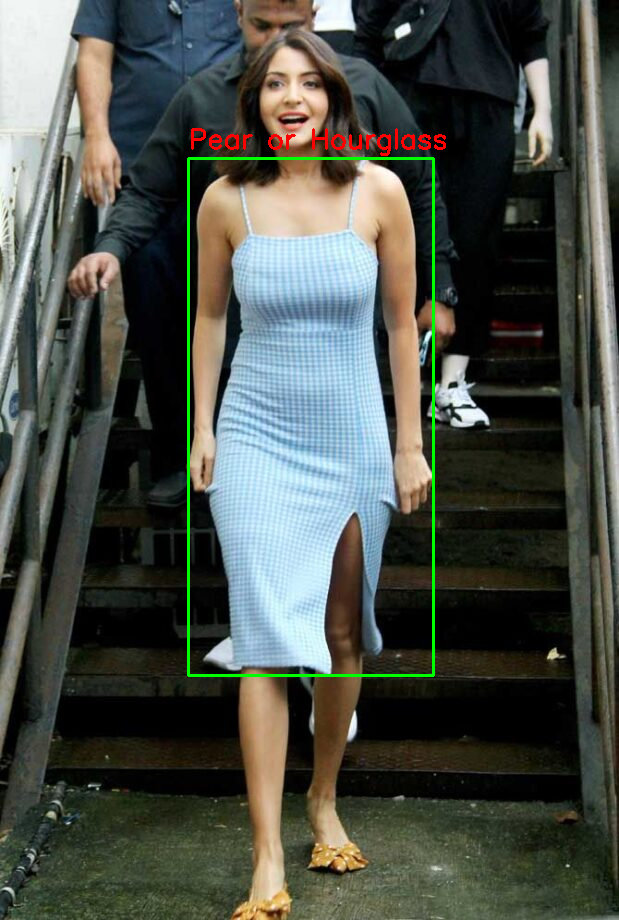

Body Shape: Pear or Hourglass


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def analyze_body_shape_with_visualization(image_path):
    """Analyzes body shape using contour detection and aspect ratios with visualization."""
    # 1. Load and preprocess the image:
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

    # 2. Find contours:
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Handle case where no contours are found
    if not contours:
        print("No contours found in the image.")
        return "Undefined"

    largest_contour = max(contours, key=cv2.contourArea)

    # 3. Get bounding rectangle and calculate aspect ratio:
    x, y, w, h = cv2.boundingRect(largest_contour)
    aspect_ratio = float(w) / h

    # 4. Determine body shape based on aspect ratio:
    if aspect_ratio > 1.2:
        body_shape = "Rectangle or Inverted Triangle"  # Wider than tall
    elif aspect_ratio < 0.8:
        body_shape = "Pear or Hourglass"  # Taller than wide
    else:
        body_shape = "Rectangle or Hourglass"  # Relatively balanced

    # 5. Visualization:
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), 3)  # Draw contour in white
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding rectangle in green
    cv2.putText(img, body_shape, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    cv2_imshow(img)  # Display the image with visualization

    return body_shape

# Example usage:
image_path = "/content/bodytype.jpg"
body_shape = analyze_body_shape_with_visualization(image_path)
print("Body Shape:", body_shape)